## Only for GDrive

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
!pwd

%cd /content/drive/My Drive/EVA4/S-15B-Assginment-Solution

/content
/content/drive/My Drive/EVA4/S-15B-Assginment-Solution


## Uncomment for the first run

In [0]:
# !cp /content/drive/My\ Drive/EVA4/S-15-Assignment-Solution/Dataset-15B/Dataset.zip /content

In [0]:
# ! mkdir Dataset
# ! unzip /content/Dataset.zip -d Dataset

## Model Summary

In [0]:
from model import DepthMaskResnetModel,DepthMaskModelV2, DepthMaskModelV6_56x56, DepthMaskModelV5_56x56
from torchsummary import summary
import torch

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

mymodel = DepthMaskModelV5_56x56.Model().to(device)
summary(mymodel, input_size=(3, 56, 56))

print("GPU count ",torch.cuda.device_count())


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 56, 56]             864
       BatchNorm2d-2           [-1, 32, 56, 56]              64
              ReLU-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          18,432
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
         Dropout2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]          73,728
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
        Dropout2d-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         294,912
      BatchNorm2d-13          [-1, 256, 56, 56]             512
             ReLU-14          [-1,

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Dataloader from custom dataset

In [0]:
from Dataloader import get_data_loaders
from albumentationsTransformations import AlbumentationsTransforms

train_transforms = AlbumentationsTransforms(mode='train')
test_transforms = AlbumentationsTransforms(mode='test')
trainloader,testloader = get_data_loaders(100000,110000,295000,300000,train_transforms,test_transforms,32)



Is CUDA available:  True
Hooo Laaa
Input and Label data count  ..........40000
Hooo Laaa
Input and Label data count  ..........20000


### Train and save the model parameters

In [0]:
!pip install pytorch_msssim
from traintest import train, test
import importlib
importlib.reload(train)
import torch.optim as optim
import torch.nn as nn
from utils import load_checkpoint


optimizer = optim.SGD(mymodel.parameters(), lr=0.003, momentum=0.9, weight_decay=0.0005)
start_epoch = 0
############################# Load saved model #################################
file_path = 'Depth_Mask_ModelV5_56_0_400000_v10-colab-transform-final.pt'
mymodel, optimizer, start_epoch, loss = load_checkpoint(mymodel, optimizer, file_path, device)

################################################################################


criterion = nn.BCELoss()
EPOCHS = start_epoch + 5
for epoch in range(start_epoch+1, EPOCHS):  # loop over the dataset multiple times
    print("EPOCH: ", epoch)
    train.train(mymodel, device, trainloader, epoch, optimizer, criterion)
    #Save the model for future use.
    torch.save({'epoch':epoch,
                'model_state_dict': mymodel.state_dict(),
               'optimizer_state_dict': optimizer.state_dict()
              }, 'Depth_Mask_ModelV5_56_0_400000_v10-colab-transform-final.pt')
    test.test(mymodel, device, testloader, criterion)

  0%|          | 0/313 [00:00<?, ?it/s]

Finished Training
Finished Training
=> loading checkpoint 'Depth_Mask_ModelV5_56_0_400000_v10-colab-transform-final.pt'
=> loaded checkpoint 'Depth_Mask_ModelV5_56_0_400000_v10-colab-transform-final.pt' (epoch 11)
EPOCH:  12


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Loss=0.17057371139526367 Batch_id=312 Accuracy=80.68: 100%|██████████| 313/313 [09:19<00:00,  1.79s/it]
  0%|          | 0/313 [00:00<?, ?it/s]


Test Set: Average loss: 0.52 , Accuracy: (0.56%)

EPOCH:  13


Loss=0.17797809839248657 Batch_id=312 Accuracy=80.35: 100%|██████████| 313/313 [09:15<00:00,  1.77s/it]
  0%|          | 0/313 [00:00<?, ?it/s]


Test Set: Average loss: 0.51 , Accuracy: (0.56%)

EPOCH:  14


Loss=0.16822633147239685 Batch_id=312 Accuracy=80.49: 100%|██████████| 313/313 [09:24<00:00,  1.80s/it]
  0%|          | 0/313 [00:00<?, ?it/s]


Test Set: Average loss: 0.51 , Accuracy: (0.56%)

EPOCH:  15


Loss=0.151871919631958 Batch_id=312 Accuracy=82.57: 100%|██████████| 313/313 [09:22<00:00,  1.80s/it]


## Miscellaneous 

## Display Train mask output Images

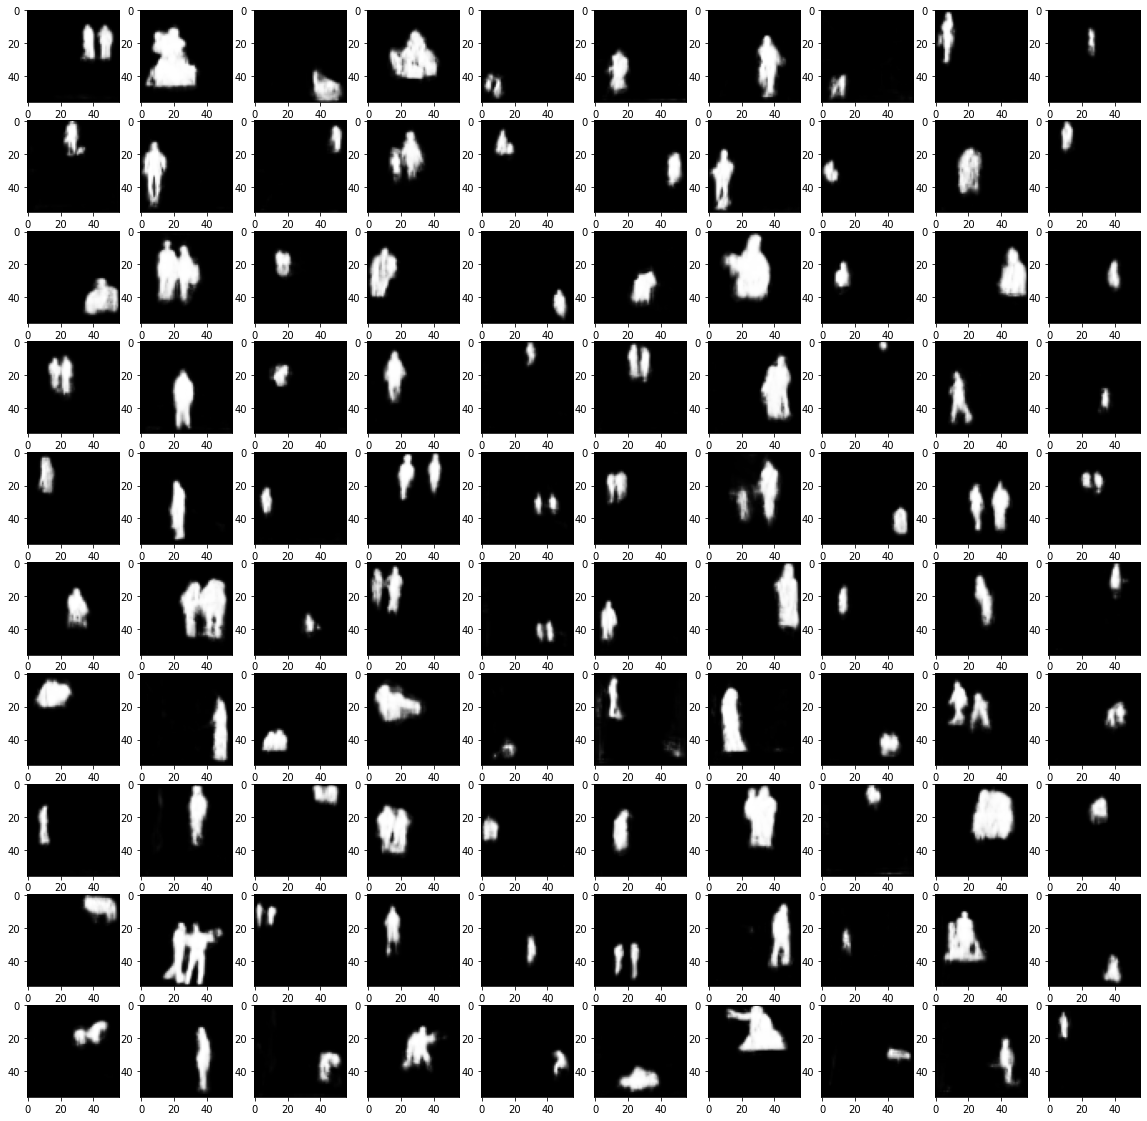

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from itertools import zip_longest

%matplotlib inline
depth_image_list = train.output_images_mask[:-1]

rows = 10
cols = 10
_, axes1 = plt.subplots(rows, cols, figsize=(20, 20))
axes1 = axes1.flatten()


for tnsr,ax in zip_longest(depth_image_list, axes1):
  for i in range(tnsr.shape[0]):
    img = tnsr[i].detach()
    img = transforms.ToPILImage()(img.cpu())
    if ax is not None:
        ax.imshow(img, cmap="gray")
plt.show()

## Display Test mask output Images

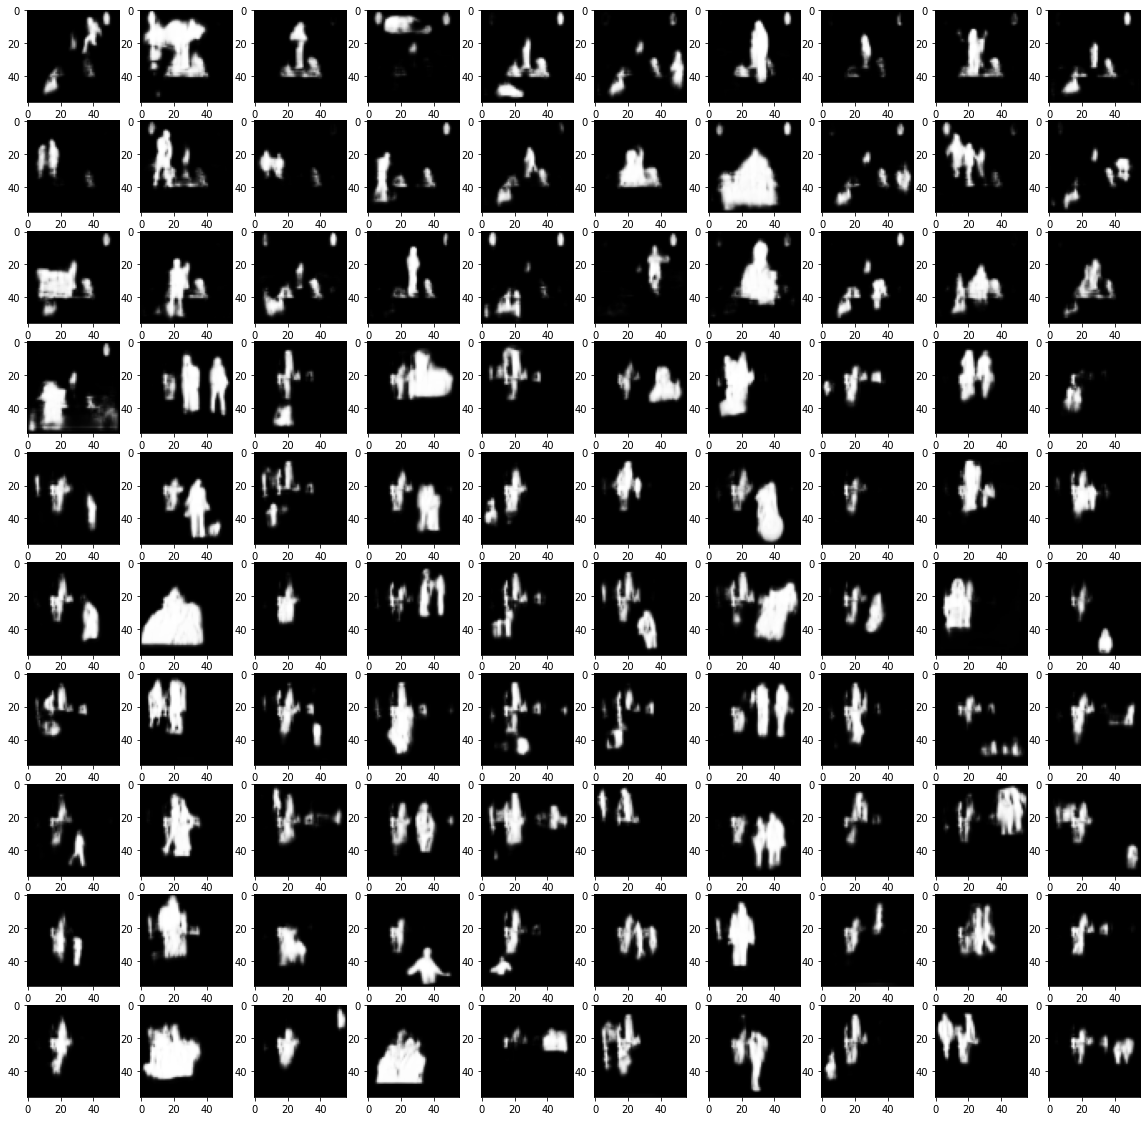

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from itertools import zip_longest

%matplotlib inline
depth_image_list = test.output_images_mask[:-1]

rows = 10
cols = 10
_, axes1 = plt.subplots(rows, cols, figsize=(20, 20))
axes1 = axes1.flatten()


for tnsr,ax in zip_longest(depth_image_list, axes1):
  for i in range(tnsr.shape[0]):
    img = tnsr[i].detach()
    img = transforms.ToPILImage()(img.cpu())
    if ax is not None:
        ax.imshow(img, cmap="gray")
plt.show()

## Display Train depth output Images

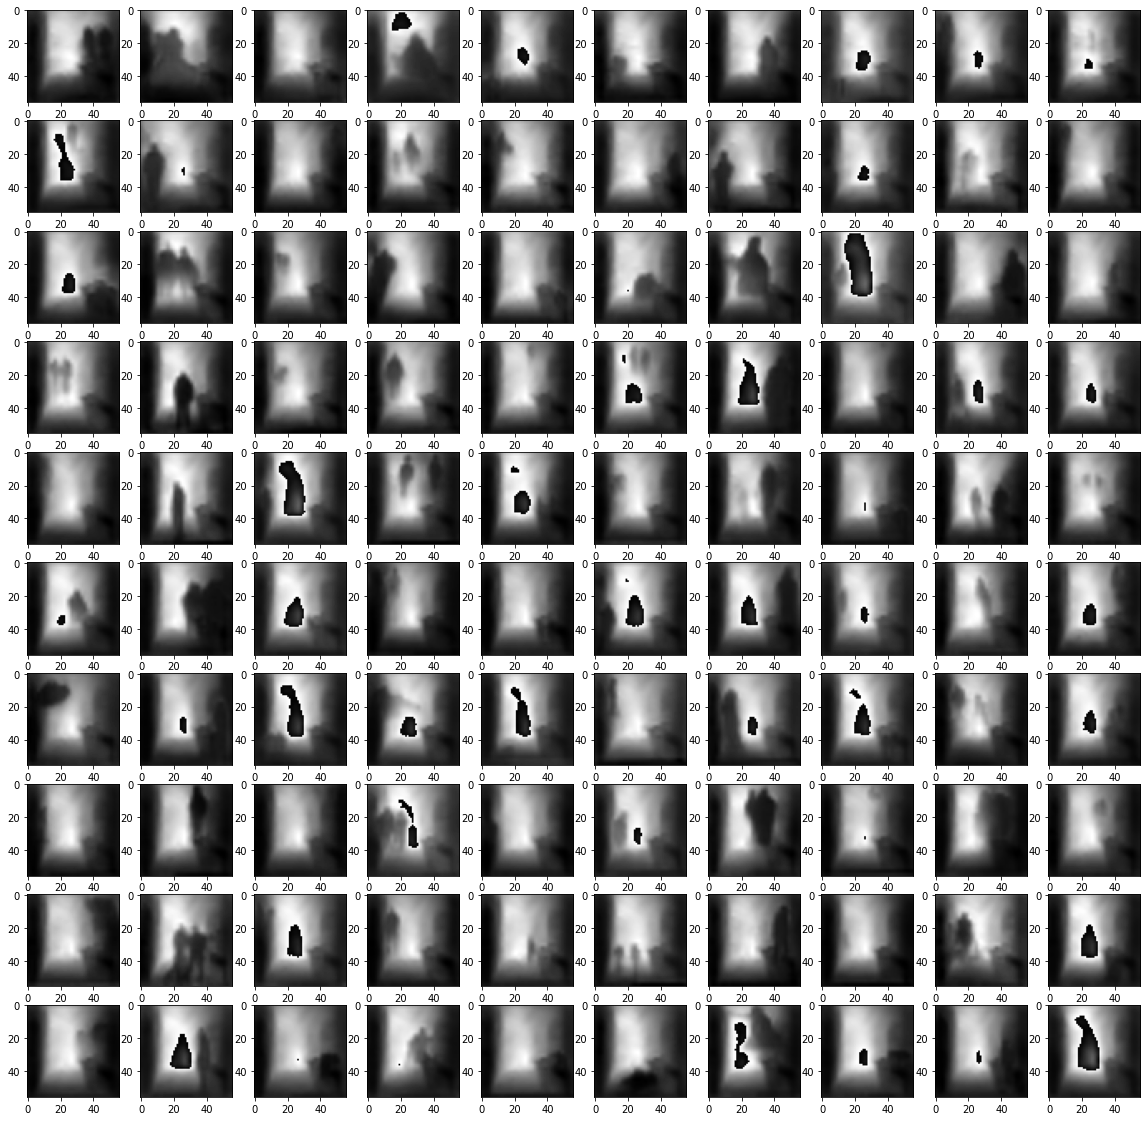

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from itertools import zip_longest

%matplotlib inline
depth_image_list = train.output_images_depth[:-1]

rows = 10
cols = 10
_, axes1 = plt.subplots(rows, cols, figsize=(20, 20))
axes1 = axes1.flatten()


for tnsr,ax in zip_longest(depth_image_list, axes1):
  for i in range(tnsr.shape[0]):
    img = tnsr[i].detach()
    img = transforms.ToPILImage()(img.cpu())
    if ax is not None:
        ax.imshow(img, cmap="gray")
plt.show()

## Display Test depth output Images

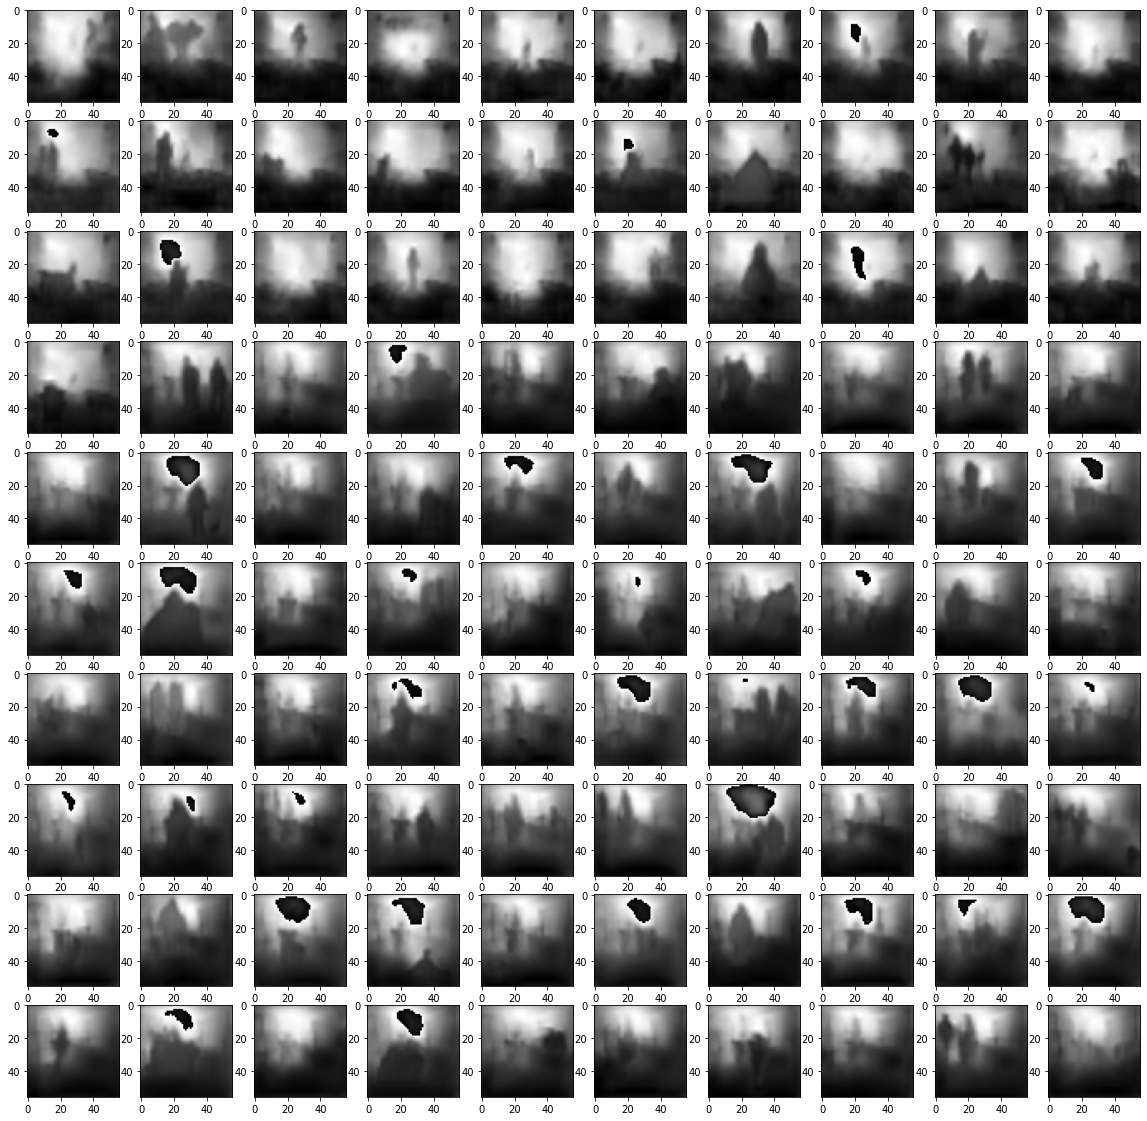

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from itertools import zip_longest

%matplotlib inline
depth_image_list = test.output_images_depth[:-1]

rows = 10
cols = 10
_, axes1 = plt.subplots(rows, cols, figsize=(20, 20))
axes1 = axes1.flatten()


for tnsr,ax in zip_longest(depth_image_list, axes1):
  for i in range(tnsr.shape[0]):
    img = tnsr[i].detach()
    img = transforms.ToPILImage()(img.cpu())
    if ax is not None:
        ax.imshow(img, cmap="gray")
plt.show()

## Train Test Acc VS Loss graph

In [0]:
import matplotlib.pyplot as plt 

y = train.train_losses
x = train.train_acc 
plt.plot(x, y, color='blue') 
plt.xlabel('Train Acc') 
plt.ylabel('Train Loss') 
plt.title('Train Accuracy vs Loss') 
plt.show()

y = test.test_losses
x = test.test_acc 
plt.plot(x, y, color='red') 
plt.xlabel('Test Acc') 
plt.ylabel('Test Loss') 
plt.title('Test Accuracy vs Loss') 
plt.show()
